# Applied Statistical Tests

In the previous chapter we introduced descriptive statistics and hypothesis testing.  In this chapter we will make extensive use of the concepts covered to introduce you to:

* A/B testing
* Multivariate testing

## A/B Testing

The foundational idea behind A/B testing is, what if we changed just one thing, would that matter?  More specifically, what if we presented two variants of one thing to a group of people, would there be a difference?

Let's start with an example.

### Inquiry

Suppose you work for a company that makes towels, and they want to send an email, like they've done many times in the past, to see how much this email affects sale of their towels.  Now let's say that, in the past 10 percent of the people sent the email bought a towel.  But, we aren't sure if this email maximizes profits.  In other words, would a different email mean we make more profit?  

### Set Up

In order to test this question, we can set up an experiment.  Here we will set up a randomized test group and a randomized control group.  

The test group will be sent an email, with slightly different copy, or possibly with a picture.  Some specific change will be made, in any event.

The control group will get the same email as last time.  This way, we can directly compare, as much as possible between the old email and the new one.  There are many things you typically need to control for, or account for in experimental design.  Some things to account for in this scenario are:

1) Age

2) Gender

3) Location

4) Time of Day

5) Time of Year

6) Approximate Disposable Income

By setting up the experiment with a test and control group, we account for time of day and time of year directly.  Some of the other information like location, age, gender, and approximate disposable income; we may not be able to account for.  Some of this may be accounted by selecting randomly from our population.  But there is no guarantee of that.  It is best to account for as many variables of interest as you can, while remaining ethical.  We will cover the ethics of variable accounting in the next section in detail.

### Running Our Example

In order to evaluate our set up, we will assume that our conversion rate follows a Bernoulli random variable.

### Bernoulli Random Variables

Informally, we can think of a Bernoulli random variable as a model for the set of possible outcomes of any single experiment.

Specifically, a Bernoulli random variable takes on value '1' with probably `p`, and value '0' with probability `1-p`.  

For our case, a value of '1' represents a person who chose to buy a towel by going to the website after reading our email.  The value of '0' represents no towel being bought after reading our email.

### An Aside Regarding Assumptions

By setting up our experiment in this way, we have actually assumed quiet a bit.  Let's formally state our assumptions here.  It is good practice, generally speaking to always list out your assumptions and confirm with a domain experiment, someone who knows the problem, but maybe not the statistics, before caring out any experiments.  If you work in a place where tasks are created for you, then before you get started, it's a good idea to confirm with the person who created the task, to make sure you are both aligned on assumptions.

### Making Our Assumptions Explicit

1) We assume here that the only reason a person would buy a towel is because of this email.

This is a pretty strong assumption.  Specifically we are only looking at the marginal effect of changing the language in an email.  It could be the case that our entire control group or our entire test group happened to need a new towel, and this email reminded them.  It could be all of the people in group one or group two just moved, and didn't have _any_ towels.  Or it could be that everyone in a group always buys things due to a sale.  

We could control for some of this stuff, which will be touched upon in a later section.  But for now, we aren't controlling for any of it.  

2) We assume non-uniformity of preferences.

A preference is a propensity or likelihood to consume a product, given the choice to consume it and the ability.  So if you are more likely to consume chocolate ice cream over vanilla ice cream given the choice between the two, and the money to buy either, then we say you have a preference for chocolate ice cream.

By assuming non-uniformity of preferences, we are saying, implicitly that there is some utility function for towels for each individual.  And that at price `towel_price`, you will not buy, because it would cost more than the utility you would derive.  But at price `towel_sale_price`, you will buy, because it would cost less than the utility you would derive.

3) We assume evenly distributed life circumstances.

We assume everyone on this email is capable of buying a towel from us.  This may seem like a riddiculous assumption, but what it's really not.  You have no idea what circumstance someone is in.

4) We assume evenly distributed access to the email

What if everyone who didn't buy a towel deactivated their email, or died, or doesn't speak english, or possibly, that their email client filtered out the email.  If we don't know for sure, we don't know the effectiveness of the email campaign.

The reason it's important to explicitly state your assumptions, is not necessarily for the code itself.  Although it can inform the tests you run or the models you create.  The most important reason to write down your assumptions is for future people working with your code, which is more often than not yourself, as well as for your managers.  

## Simulating Some Data

In [88]:
from scipy import stats

test_size = 1000
control_size = 1000
test_probability = 0.15
control_probability = 0.1
test_dist = stats.bernoulli(test_probability)
control_dist = stats.bernoulli(control_probability)

Note: we don't actually know the test probability, so "pretend" you can't see it.  We wouldn't know this for the population in the real world.  Also, we probably can't be "sure" our process follows a Bernoulli random variable.  It could be some other generative process, like this:

In [89]:
import random

def generative_process():
    random_number = random.randint(0, 100)
    if random_number < 15:
        return 1
    elif random_number % 2 == 0:
        return 0
    else:
        return 1
    
[generative_process() for _ in range(10)]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0]

The important difference here is there are multiple cases by which our generative process outputs a '1', which we may be important!  The more you know about your underlying data generation process, the better.  But usually it is impossible to discern this.  The important thing to note is, this is an assumption.

In [90]:
import pandas as pd
import numpy as np

test_df = pd.DataFrame()
test_df["converted"] = test_dist.rvs(size=test_size)
test_df["group"] = "test"
control_df = pd.DataFrame()
control_df["converted"] = control_dist.rvs(size=control_size)
control_df["group"] = "control"
df = test_df.append(control_df)

In [91]:
summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
summary['total'] = df.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
summary['rate'] = df.pivot_table(values='converted', index='group')
summary

,converted,total,rate
group,,,
control,106,1000,0.106
test,137,1000,0.137


We may believe our test was successful at this point, and in fact, we are done.  However, how do we know that our test was successful?  How do we know that the two samples differences weren't just because of demographic differences?  Time to verify against all of the assumptions we made in the prior section!

In order to do this we will look at the chi-squared test.  Recall, the chi-squared test's null hypothesis states the two variables are independent.  One could also think of the null hypothesis as, "is there a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table".  

This sounds perfect!  So let's bring in our other variables:

* Age
* Gender
* Location
* Race

Note: Here we assume that location is a proxy for income.  So we'll specify location as high, medium and low; where high means an expensive area to live, medium means a middle class area to live, and low means a poor area to live.

Note: We will specify Gender as a binary variable.  While in the real world this assumption is not valid, we will make this simplifying assumption here.

Note: For Race we will specify one of four categories:
* white
* black
* asian
* hispanic

While this does not encompass all of the races, it works as a simplifying set of assumptions, for this example.

Note: For Age we will specify one of five categories:
* 18-24
* 24-35
* 35 - 50
* 50 - 70
* 70+

Now let's generate some data:

In [92]:
import random

def generate_data(df, column, choices):
    """
    Generates categorical data given choices.
    
    Parameters:
    * df - pd.DataFrame: the data to add a column to
    * column - str: the column to generate
    * choices - list: the list of possible choices
    
    Returns:
    A dataframe with the newly generated column.
    """
    df[column] = [random.choice(choices)
                  for _ in range(df.shape[0])]
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    df = df.drop(column, axis=1)
    return df

def generate_contingency_table(df, demographics):
    """
    Generates a contingency table from a list of choices.
    We hard code converted, because that is 'always' one of the variables of interest.
    
    Parameters:
    * df - pd.DataFrame: the dataframe to convert to a contingency table.
    * demographics - list: a list of demographics, aka the classes from
    all categorical classes of interest.
    
    Note: one way to get the demographics is:
    categories = []
    for column in categorical_columns:
        categories += list(df[column].unique())
    """
    summary = df.pivot_table(values='converted', index='group', aggfunc=np.sum)
    for demographic in demographics:
        summary[demographic] = df.pivot_table(
            values=demographic,
            index="group",
            aggfunc=np.sum
        )
    return summary

gender_choices = ["male", "female"]
age_choices = ["18-24", "24-35", "35-50", "50-70", "70+"]
race_choices = ["white", "black", "asian", "hispanic"]
location_choices = ["high", "medium", "low"]

test_df = generate_data(test_df, "gender", gender_choices)
test_df = generate_data(test_df, "age", age_choices)
test_df = generate_data(test_df, "race", race_choices)
test_df = generate_data(test_df, "location", location_choices)
control_df = generate_data(control_df, "gender", gender_choices)
control_df = generate_data(control_df, "age", age_choices)
control_df = generate_data(control_df, "race", race_choices)
control_df = generate_data(control_df, "location", location_choices)

df = pd.DataFrame()
df = df.append(test_df)
df = df.append(control_df)

# does list concatenation
demographics = gender_choices + age_choices + race_choices + location_choices
table = generate_contingency_table(df, demographics)

Before we run our hypothesis test, let's look at our contingency table!

In [93]:
table

,converted,male,female,18-24,24-35,35-50,50-70,70+,white,black,asian,hispanic,high,medium,low
group,,,,,,,,,,,,,,,
control,106,500.0,500.0,199,223,194,205,179,249,234.0,255.0,262.0,301.0,350.0,349.0
test,137,531.0,469.0,205,207,204,187,197,231,258.0,256.0,255.0,332.0,329.0,339.0


In [99]:
import pandas
from scipy.stats import chi2_contingency

table_transpose = table.T
chi2, pvalue, degrees_of_freedom, expected = chi2_contingency(table_transpose)

chi2, pvalue

(12.641590172199018, 0.5549187908439822)

Let's go over the definitions of each of these:

* chi2 - this is the test statistic.  It is calculated as a normalized sum of squared deviations between observed and theoretical frequencies.  In the two group setting we can take one as the observation and the other as the theoretical.

* p value - this is the probability value of obtaining test results at least as extreme as the results actually observed during the test, assuming the null hypothesis is correct.  So the lower the p value, the more likely we are to reject the null hypothesis.

* degress of freedom - since we are doing the test for homogenity, here the degrees of freedom are:

$$ df = (Rows - 1) * (Columns -1)  $$ 

Where Rows := number of categories, aka the rows of the contingency table.

Where Columns := number of independent groups

Notice, we satisfy this requirement by taking the transpose of the contingency table

* expected value - this is the theoretical values for the contingency table, given the null hypothesis is true.

### Analyzing Our Test

Now let's see what our test tells us about our data.  First let's explicitly state the null hypothesis and alternative hypothesis:

* null hypothesis: there exists no relationship between the two groups.  If the null hypothesis is true, then it might be the case that the difference in our conversion rates is significant.

* alternative hypothesis: there exists a relationship between the two groups.  In other words, the two groups are statistically similar.  If this is the case, then it might be that the difference in our conversion rates is due to chance.

Based on the p-value, it looks like we fail to reject our null hypothesis.  With a test statistic of approximately 12.64, the normalized sum of squared deviations appears large enough that there is no relationship.  This appears to confirm what our contingency table seemed to be telling us.  Let's go a little deeper.

Let's next verify, for academic purposes that the degrees of freedom match up with what we expect:

In [101]:
degrees_of_freedom == (table.shape[0]-1) * (table.shape[1]-1)

True

Now, just for comparison, let's look at the expected values:

In [106]:
pd.DataFrame(expected, columns=table_transpose.columns, index=table_transpose.index).T

,converted,male,female,18-24,24-35,35-50,50-70,70+,white,black,asian,hispanic,high,medium,low
group,,,,,,,,,,,,,,,
control,121.043067,513.561325,482.677909,201.240325,214.191435,198.251607,195.26289,187.292976,239.097416,245.074851,254.539124,257.527842,315.309717,338.22322,342.706296
test,121.956933,517.438675,486.322091,202.759675,215.808565,199.748393,196.73711,188.707024,240.902584,246.925149,256.460876,259.472158,317.690283,340.77678,345.293704


In [108]:
table

,converted,male,female,18-24,24-35,35-50,50-70,70+,white,black,asian,hispanic,high,medium,low
group,,,,,,,,,,,,,,,
control,106,500.0,500.0,199,223,194,205,179,249,234.0,255.0,262.0,301.0,350.0,349.0
test,137,531.0,469.0,205,207,204,187,197,231,258.0,256.0,255.0,332.0,329.0,339.0


Now let's verify our calculation of test statistic:

In [115]:
summation = 0
expected_df = pd.DataFrame(
    expected, columns=table_transpose.columns, 
    index=table_transpose.index).T
for index, row in table_transpose.iterrows():
    for column in table_transpose.columns:
        deviation = row[column] - expected_df[index][column]
        deviation_squared = deviation ** 2
        normed_deviation_squared = deviation_squared / expected_df[index][column]
        summation += normed_deviation_squared
summation

12.641590172199018

In [116]:
summation == chi2

True

Success!  Now we are sure that we have some belief that our test and control are different, accounting for at least some demographic variables, we are ready to do our final exploration.  

This is an important point - if something passes a hypothesis test (or fails) that does not mean that the test is conclusive.  That's why I used the word may.  When you do statistics, machine learning, data science or whatever we are calling it these days, you should build up evidence that you believe your hypothesis is true.  You should imagine perhaps a court room, or some other sort of collection of people, that you have to convince of your results.  

Each piece of evidence you bring to the table helps you make your case, but it does not and likely will not lead to a conclusive pattern.  It can only give you more of a chance that your hypothesis is right or wrong.  This is in direct conflict with the business world, where everything usually moves pretty fast.  But, if you build up the right tooling and can replicate the scientific process quickly, you can usually at least develop some confidence in what you are seeing.

With this in mind we move onto the next leg in our scientific journey, data visualization.

## Visualizing Categorical Data


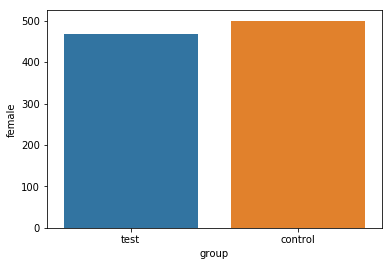

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

gender_data = pd.DataFrame()
gender_data = gender_data.append({
    "female": df[df["group"] == "test"]["female"].sum(),
    "group": "test"
}, ignore_index=True)
gender_data = gender_data.append({
    "female": df[df["group"] == "control"]["female"].sum(),
    "group": "control"
}, ignore_index=True)

sns.barplot(x="group", y="female", data=gender_data)
plt.show()

As you can see it looks like there is a pretty close to even gender split between test and control, so we can probably rule out that lone interaction as the source of our variance.

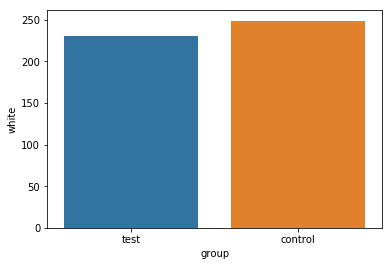

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

ethnicity_data = pd.DataFrame()
ethnicity_data = ethnicity_data.append({
    "white": df[df["group"] == "test"]["white"].sum(),
    "group": "test"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "white": df[df["group"] == "control"]["white"].sum(),
    "group": "control"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "black": df[df["group"] == "control"]["black"].sum(),
    "group": "control"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "black": df[df["group"] == "test"]["black"].sum(),
    "group": "test"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "asian": df[df["group"] == "control"]["asian"].sum(),
    "group": "control"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "asian": df[df["group"] == "test"]["asian"].sum(),
    "group": "test"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "hispanic": df[df["group"] == "control"]["hispanic"].sum(),
    "group": "control"
}, ignore_index=True)
ethnicity_data = ethnicity_data.append({
    "hispanic": df[df["group"] == "test"]["hispanic"].sum(),
    "group": "test"
}, ignore_index=True)

sns.barplot(x="group", y="white", data=ethnicity_data)
plt.show()

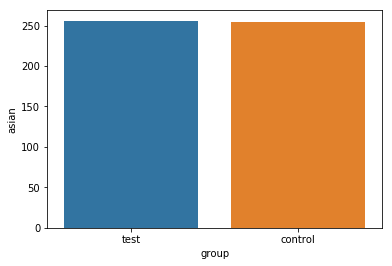

In [134]:
sns.barplot(x="group", y="asian", data=ethnicity_data)
plt.show()

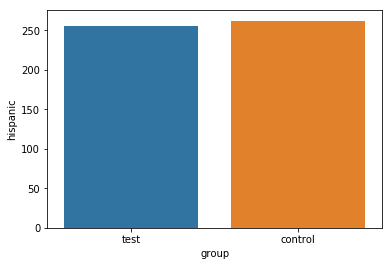

In [135]:
sns.barplot(x="group", y="hispanic", data=ethnicity_data)
plt.show()

The three groups:
* white
* asian
* hispanic 

all appear to have very little variation.  However, as we can see below, the difference in size between black folks from test and control appears to be different.  

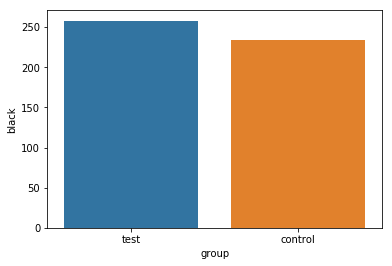

In [133]:
sns.barplot(x="group", y="black", data=ethnicity_data)
plt.show()

It's worth it to note that because this data was entirely randomly generated, there is no implicit data generation process to analyze, but if this were the real world, I would say this information warrants further inquiry.  In fact, if this were the real world, it may be enough evidence to explain the variation in the difference between test and control.  We will look at how we would measure that next.  But do keep in mind, we may not find anything in this case because the data was randomly generated.  And in fact, any conclusions we do draw will be entirely by chance.



In [149]:
black_data = df[["black", "converted", "group"]]

t = ~black_data["converted"].astype(bool)
t.map({True: 1, False: 0})

black_data["black_converted"] = black_data["black"] & black_data["converted"]
black_data["other_converted"] = ~black_data["black"] & black_data["converted"]
black_data["black_not_converted"] = black_data["black"] & ~black_data["converted"]
black_data["other_not_converted"] = ~black_data["black"] & ~black_data["converted"]

#sns.countplot(x="group", hue="black_converted", data=black_data)

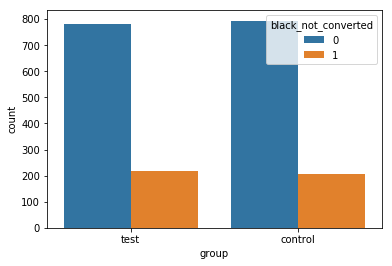

In [145]:
sns.countplot(x="group", hue="black_not_converted", data=black_data)

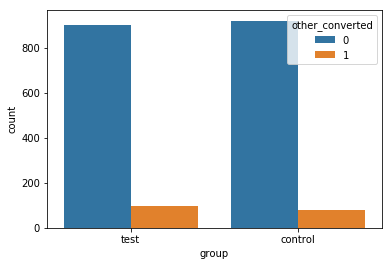

In [143]:
sns.countplot(x="group", hue="other_converted", data=black_data)

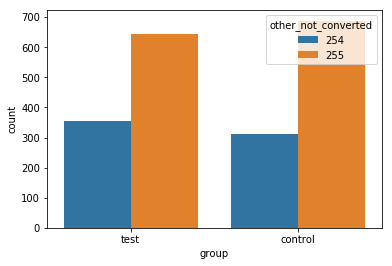

In [146]:
sns.countplot(x="group", hue="other_not_converted", data=black_data)